# DPX Temperature Analysis

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import hickle, cPickle
%matplotlib inline

import plotTemperatureToT as pttt
import ToTtoEnergy as tte
reload(tte)

sys.path.insert(0, '../../energy_calibration/rebin/')
import rebin as rb

## Input Files

In [2]:
infile = 'temperatureToT_5.hck'

## Combine files

In [3]:
# energyList = [30, 40, 50, 75, 100, 125, 148]
# infileList = ['temperatureToT_wSensor/temperatureToT_%d.p' % energy for energy in energyList]
energyList = [25, 75, 125]
infileList = ['temperatureToT/DPX22/temperatureToT_DPX22_%dkeV.hck' % energy for energy in energyList]

def combineFiles(infileList, energyList):
    # Get first file
    if infileList[0].endswith('.p'):
        d = cPickle.load(open(infileList[0], 'rb'))
    else:
        d = hickle.load(infileList[0])

    # Add energy column if needed
    if not 'energy' in d.keys():
        energy = energyList[0] * 1000
        d['energy'] = [energy]*len(d['time'])

    dim = min(len(d['energy']), len(d['ToT']), len(d['time']))
    for key in d.keys():
        d[key] = d[key][:dim]
        
    for idx, infile in enumerate(infileList[1:]):
        print infile
        if infileList[idx].endswith('.p'):
            d_ = cPickle.load(open(infile, 'rb'))
        else:
            d_ = hickle.load(infile)
                        
        if not 'energy' in d_.keys():
            energy = energyList[idx+1] * 1000
            d_['energy'] = [energy]*len(d_['time'])
            
        dim = min(len(d_['energy']), len(d_['ToT']), len(d_['time']))
        for key in d_.keys():
            d_[key] = d_[key][:dim]
            
        for key in d.keys():
            d[key] += list(d_[key])
            
    return d

tempDict = combineFiles(infileList, energyList)

temperatureToT/DPX22/temperatureToT_DPX22_75keV.hck
temperatureToT/DPX22/temperatureToT_DPX22_125keV.hck


In [4]:
print set(tempDict['energy'])
len(tempDict['energy']), len(tempDict['time']), len(tempDict['ToT'])

set([25000.0, 75000.0, 125000.0])


(695, 695, 695)

## Perform calibration and return parameters for each pixel

plotTemperatureToT.py:262: RuntimeWarning: overflow encountered in exp
  return np.where(x <= toff, offset1, np.where(x <= tmax, (Tmax - offset1)*(1 - np.exp(-tau1*(x - toff))) + offset1, (Tmax - offset2)*np.exp(-tau2*(x - tmax)) + offset2))
plotTemperatureToT.py:262: RuntimeWarning: overflow encountered in multiply
  return np.where(x <= toff, offset1, np.where(x <= tmax, (Tmax - offset1)*(1 - np.exp(-tau1*(x - toff))) + offset1, (Tmax - offset2)*np.exp(-tau2*(x - tmax)) + offset2))
/usr/lib/python2.7/dist-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


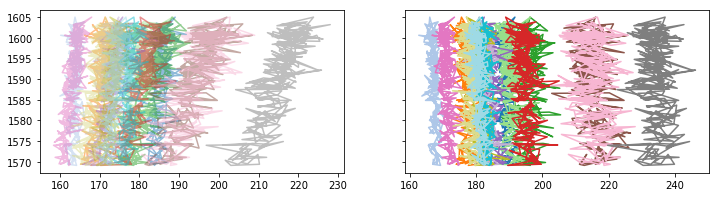

<Figure size 432x288 with 0 Axes>

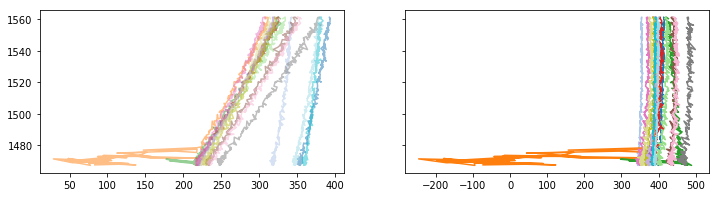

<Figure size 432x288 with 0 Axes>

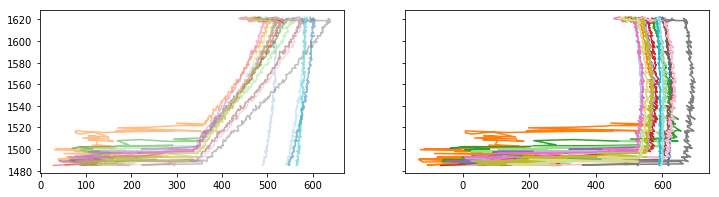

<Figure size 432x288 with 0 Axes>

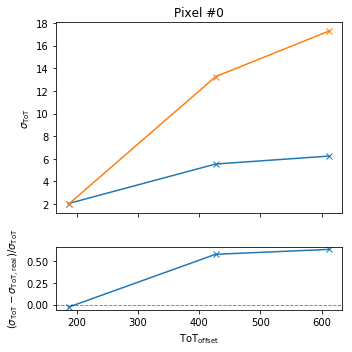

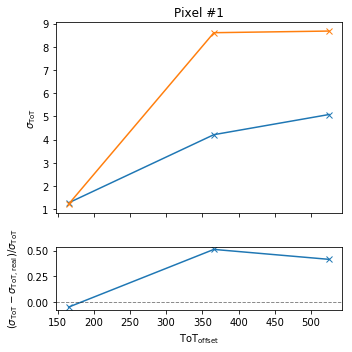

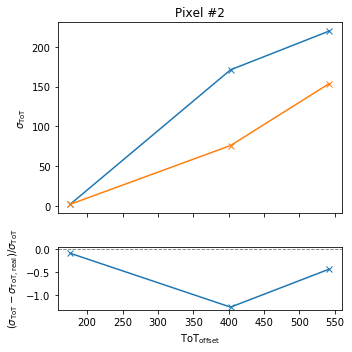

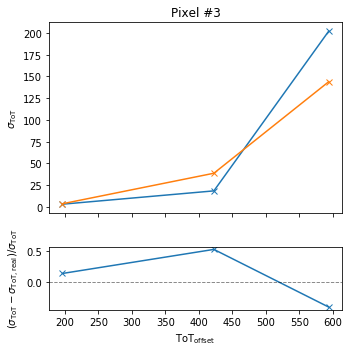

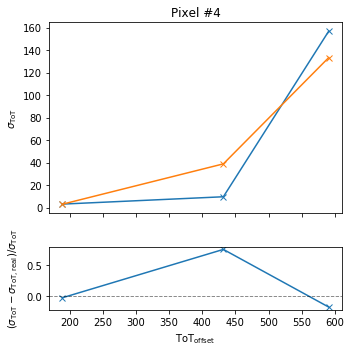

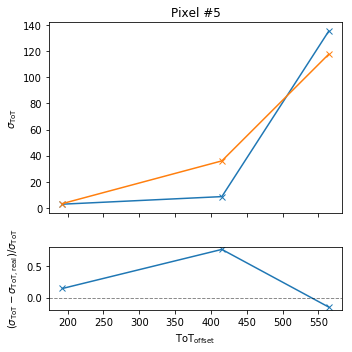

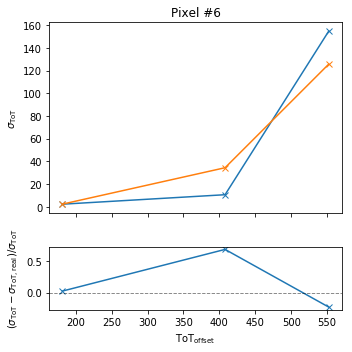

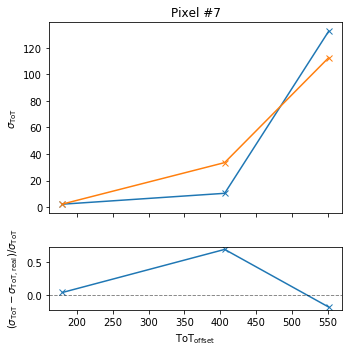

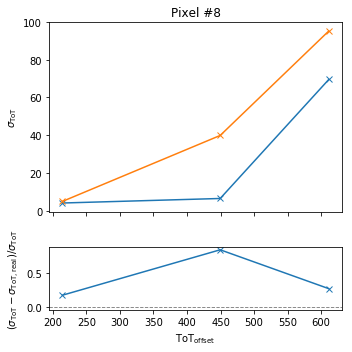

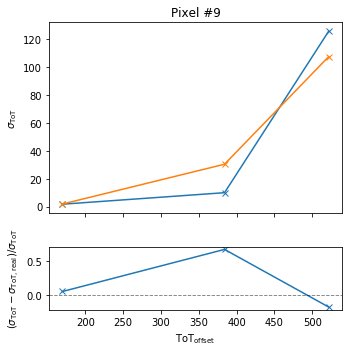

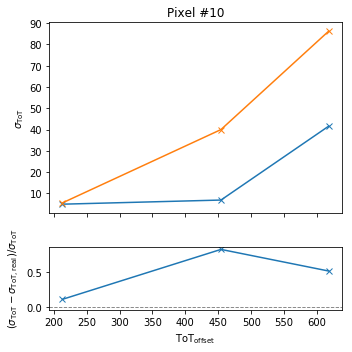

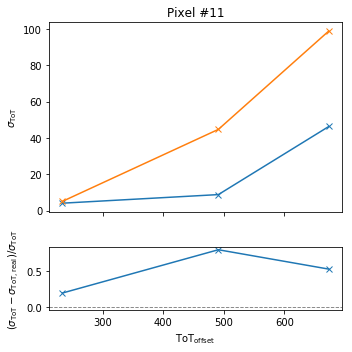

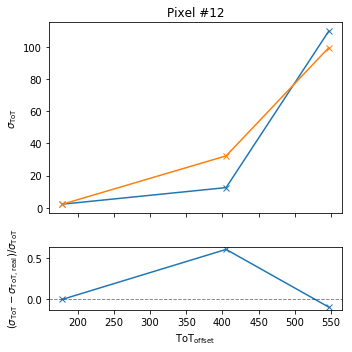

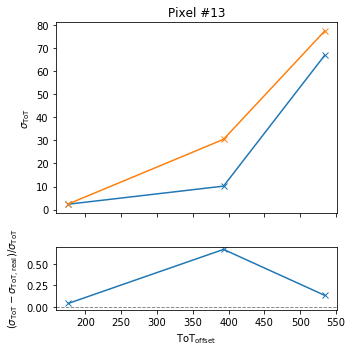

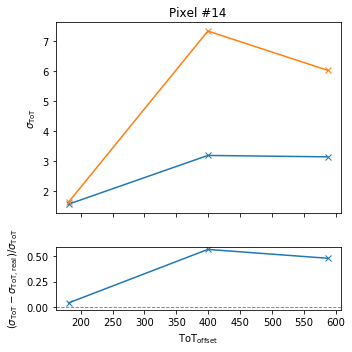

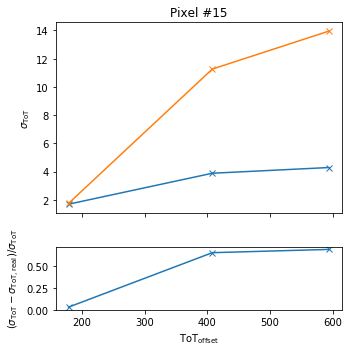

In [5]:
reload(pttt)
# Load dict from file
if infile.endswith('.p'):
    d = cPickle.load( open(infile, 'rb') )
else:
    d = hickle.load(infile)

outDict = pttt.plotTemperature(tempDict, offsettemp=1635, plot=False, outdir=None)

## Simulate temperature effects on measured data

In [6]:
# Get energy calibration coefficients
paramsDict = hickle.load('energyConversion/paramsDict_DPX22.hck')

# Load spectrum from file
ToTfnList = ['Measurements/DPX22/AmMo_raw/ToTMeasurement_%d.hck' % num for num in range(5, 11)]
dataList = [np.asarray( hickle.load(open(ToTfn, 'r'))['Slot1'] ).T for ToTfn in ToTfnList]
# Combine the data
data = np.hstack(dataList)

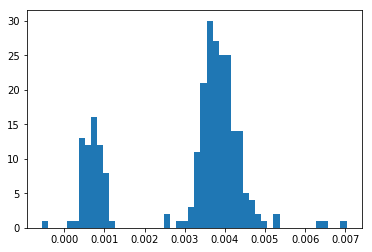

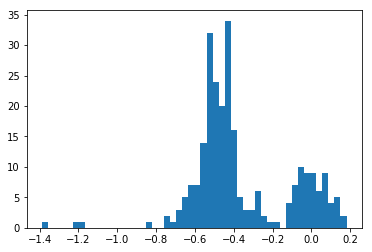

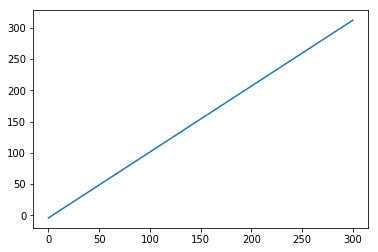

In [7]:
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']
_ = plt.hist(slope, bins=50)
plt.show()
_ = plt.hist(offset[abs(offset - np.mean(offset)) < 3*np.std(offset)], bins=50)
plt.show()

plt.plot(np.linspace(0, 300, 10), pttt.getRealToT(np.linspace(0, 300, 10), Toffset, 1650, slope[8], offset[8]))

In [8]:
def ToTtoEnergy(data, params):
    pixelData = data
    pixelData = pixelData[pixelData > 0]
    p = params
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']

    pixelDataEnergy = tte.ToTtoEnergy(pixelData, a, b, c, t, h, k)
    pixelDataEnergy = pixelDataEnergy[np.logical_and(pixelDataEnergy > 10, pixelDataEnergy <= 100)]

    return pixelDataEnergy

def ToTatT(data, T, slope, offset, Toffset):
    data = np.asarray( data )
    data = data[data > 0]
    dataAtT = pttt.getRealToT(data, T, Toffset, slope, offset)
    return dataAtT
    
def getDataAtT(data, T, slope, offset, Toffset, energy=True):
    dataEnergyList = []
    for idx in range(256):
        try:
            dataAtT = ToTatT(data[idx], T, slope[idx], offset[idx], Toffset)
            if energy:
                dataEnergy = ToTtoEnergy(dataAtT, paramsDict[idx])
            else:
                dataEnergy = dataAtT
        except:
            continue

        dataEnergyList.append( dataEnergy )
    
    return dataEnergyList
    
Toffset = 1635
TList= np.linspace(Toffset - 100, Toffset + 100, 100)
xMin, xMax = 10, 400
saveFig = False

if saveFig:
    binsList, histList = [], []
    for T in TList:
        dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=True)
        dataTemp = np.asarray( dataTemp ).flatten()
        hist, bins = np.histogram(dataTemp, bins=np.arange(xMin, xMax))
        binsList.append(bins), histList.append(hist)

    for idx in range(len(TList)):
        plt.step(binsList[idx][:-1], histList[idx], where='post', alpha=.7)
        plt.title('Temperature: %d DAC' % TList[idx])
        plt.ylim(0, 1.05*np.max(histList))
        plt.savefig('images/temperature_%d.jpg' % idx)
        plt.show()
        plt.clf()

## Bin energy data

In [195]:
def normal(x, mu, sigma):
    return 1./np.sqrt(2*sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def KDE(bins, hist):
    bins, hist = np.asarray(bins), np.asarray(hist)
    
    # Get bin widths
    binWidths = np.diff(bins)
    
    # Get bin centers
    binCenters = bins[:-1] # + 0.5 * binWidths
    
    f = lambda x: sum([hist[idx] * normal(x, binCenters[idx], .5 * binWidths[idx]) for idx in range(len(hist))])
    return f

def getCorrectedBins(bins, hist):
    # Get gradient
    grad = np.diff(np.insert(hist, 0, 0)) # / np.diff(bins)
    print grad

    binEdges = []
    binWidths = np.diff(bins[:-1])
    for i in range(len(grad) - 1):
        g1, g2 = grad[i], grad[i+1]
        b = bins[i] # + 0.5 * binWidths[i]
        bw = binWidths[i]

        if g1 == 0 and g2 == 0:
            binEdges.append(b + 0.5*bw)
            continue

        gFrac = abs(g1 / g2)
        if np.isinf(gFrac):
            gFrac = 0

        if gFrac > 1:
            gFrac = 1. / gFrac

        if g1 >= 0 and g2 >= 0:
            if gFrac < 0.5:
                gFrac = 1 - gFrac

        elif g1 < 0 and g2 < 0:
            if gFrac >= 0.5:
                gFrac = 1 - gFrac

        elif g1 >= 0 and g2 < 0:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac
            gFrac /= 2

        else:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac

        binEdges.append(b + bw * gFrac)
        print grad[i], grad[i+1], gFrac, b

    return binEdges

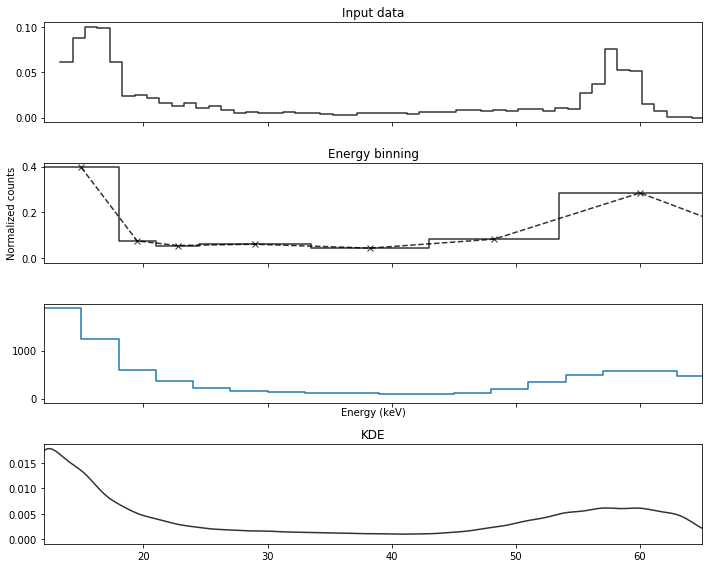

In [189]:
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
idx = 8

# Input data
pixelData = ToTtoEnergy(data[idx], paramsDict[idx])
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 100)]
histIn, binsIn = np.histogram(pixelData, bins=75)
ax[0].step(binsIn[:-1], histIn / float(np.sum(histIn)), where='post', color='k', alpha=.8)
ax[0].set_xlim(binEdges[0], 65)
ax[0].set_title('Input data')

# Apply energy bins
hist, bins = np.histogram(pixelData, bins=binEdges)
ax[1].step(bins[:-1], hist / float(np.sum(hist)), where='post', color='k', alpha=.8)
ax[1].plot(bins[:-1] + 0.5 * np.diff(bins), hist / float(np.sum(hist)), marker='x', ls='--', color='k', alpha=.8)
ax[1].set_title('Energy binning')

# Rebin energy
x = np.arange(binEdges[0], binEdges[-2], min(np.diff(binEdges))) # np.linspace(binEdges[0], binEdges[-2], 16)
x = np.append(x, binEdges[-1])
y = rb.rebin(bins, hist, x) # , interp_kind='piecewise_constant')
ax[2].step(x[:-1], y, where='post')

# Apply KDE
f = KDE(x, y)
x = np.linspace(min(bins), max(bins[:-1]), 1000)
y = f(x)
y /= np.sum(y)
ax[3].plot(x, y, color='k', alpha=.8)
ax[3].set_title('KDE')

ax[2].set_xlabel('Energy (keV)')
ax[1].set_ylabel('Normalized counts')

plt.tight_layout()
plt.show()

In [181]:
def histogramMean(bins, hist):
    return 1./np.sum(hist) * np.dot(bins[:-1], hist)

Toffset = 1635
T = Toffset + 10

# Data at specific temperature T
dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=False)
# Data at temperature Toffset
dataTempOffset = getDataAtT(data, Toffset, slope, offset, Toffset, energy=False)
plot = False

meanDict = {'corrected': [], 'actual': [], 'target': []}

histActual, histTarget, histCorrected = np.zeros(16), np.zeros(16), np.zeros(16)
for pixel in range(len(dataTemp)):
    # Convert binEdges from energy to ToT
    try:
        p = paramsDict[pixel]
    except:
        continue

    if plot:
        fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    
    binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
    if binEdgesToT[0] > binEdgesToT[1]:
        binEdgesToT[0] = 0

    if not all(binEdgesToT):
        continue
        
    # Check if binEdgesToT increas monotonically
    if np.any(np.diff(binEdgesToT) < 0):
        continue
        
    # Bin the data to simualte DosiMode
    hist, bins = np.histogram(dataTemp[pixel], bins=binEdgesToT)
    histActual += np.asarray( hist )
    
    # - Analysis start -
    # Rebin energy
    x = np.arange(binEdgesToT[0], binEdgesToT[-2], min(np.diff(binEdgesToT))) 
    x = np.append(x, binEdgesToT[-1])
    y = rb.rebin(np.asarray(bins, dtype=np.float), np.asarray(hist, dtype=np.float), np.asarray(x, dtype=np.float)) # , interp_kind='piecewise_constant')

    # f = KDE(x, y)
    # x = np.linspace(min(x), max(x[:-1]), 1000)
    # y = f(x)[:-1]
    
    # Convert to energy at Toffset
    xReal = pttt.getRealToT(x, Toffset, T, slope[pixel], offset[pixel])
    
    # Rebin back
    binEdgesToT_ = np.asarray(binEdgesToT)
    # binEdgesToT_ = np.insert(binEdgesToT_, 0, 0)
    yBack = rb.rebin(xReal, y, binEdgesToT_) # , interp_kind='piecewise_constant')
    # yBack = yBack_[1:]
    # yBack[0] += yBack_[0]
    histCorrected += np.asarray(yBack)
    # - Analysis end -
    
    histOffset, binsOffset = np.histogram(dataTempOffset[pixel], bins=binEdgesToT)
    histTarget += np.asarray(histOffset)
    
    meanDict['actual'].append( histogramMean(bins, hist) ) 
    meanDict['target'].append( histogramMean(binsOffset, histOffset) )
    meanDict['corrected'].append( histogramMean(binEdgesToT, yBack) )
            
    if plot:
        ax[0].step(bins[:-1], hist, where='post', alpha=.5)
        ax[0].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        ax[1].step(x[:-1], y, where='post', alpha=.5)
        ax[2].step(xReal[:-1], y, where='post', alpha=.5)
        ax[3].step(binEdgesToT[:-1], yBack, where='post', alpha=.5)
        ax[3].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        plt.show()
        # ax[3].set_ylim(0, 3000)

ToTtoEnergy.py:99: RuntimeWarning: invalid value encountered in less
  res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)


[  91.  148.  161.  173.  201.  228.  257.  292.  333.  375.  417.  467.
  520.  578.  651.  746. 1263.]
[ 6.33767497e-03 -2.48374663e-03  2.03617732e-05 -1.16194326e-03
 -9.10227087e-04  1.48384915e-03  5.92157203e-03 -9.20754094e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.006337674969983434 -0.002483746628616455 0.19595093156244234 91.0
-0.002483746628616455 2.0361773177250946e-05 0.00819800737428409 148.0
2.0361773177250946e-05 -0.00116194326416677 0.49123805188893954 161.0
-0.00116194326416677 -0.0009102270869524693 0.21663379355687085 173.0
-0.0009102270869524693 0.0014838491493175986 0.38657707397610463 201.0
0.0014838491493175986 0.005921572030287816 0.7494163472591455 228.0
0.005921572030287816 -0.009207540943030404 0.1784390063032999 257.0
-0.009207540943030404 0.0 0 292.0
[-45.8307969  -12.8934259   -6.10514338 -21.93425378 -16.562419
  -7.26692593 -28.75463478 -41.         -21.      

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


(0, 350)

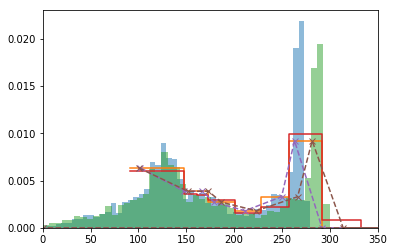

In [264]:
idx = 20
pixelData = data[idx]
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 300)]
pixelDataAtT = pttt.getRealToT(pixelData, Toffset, Toffset + 30, slope[idx], offset[idx])

p = paramsDict[idx]
binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
print binEdgesToT

_ = plt.hist(pixelData, bins=50, alpha=.5, density=True)
hist, bins = np.histogram(pixelData, bins=binEdgesToT, density=True)
plt.step(bins[:-1], hist, where='post')

_ = plt.hist(pixelDataAtT, bins=50, alpha=.5, density=True)
histAtT, binsAtT = np.histogram(pixelDataAtT, bins=binEdgesToT, density=True)
plt.step(binsAtT[:-1], histAtT, where='post')
binEdgesCorr = getCorrectedBins(bins, hist)
plt.plot(np.append(binEdgesCorr, 0), hist, marker='x', ls='--')

binsAtT = pttt.getRealToT(binEdgesCorr, Toffset, Toffset + 30, slope[idx], offset[idx])
plt.plot(np.append(binsAtT, 0), hist, marker='x', ls='--')

print (binEdgesCorr - binEdgesToT[1:-1])
plt.xlim(0, 350)

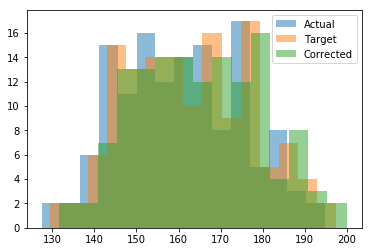

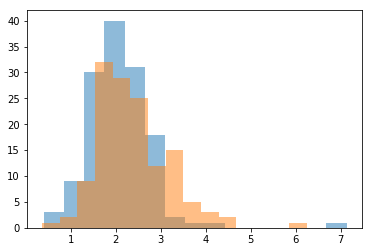

[ 3.56120e+05 -3.01466e+05 -6.39400e+03  2.78250e+04 -2.71120e+04
  6.96300e+04  1.80961e+05 -2.99495e+05 -1.00000e+01  2.00000e+00
 -4.30000e+01 -1.10000e+01 -5.00000e+00  0.00000e+00 -1.00000e+00
 -1.00000e+00]
356120.0 -301466.0 0.4232646299000337 12
-301466.0 -6394.0 0.021209688654773674 18
-6394.0 27825.0 0.7702066486972148 21
27825.0 -27112.0 0.4871877807726865 24.5
-27112.0 69630.0 0.6106276030446647 33.5
69630.0 180961.0 0.615220959212206 43
180961.0 -299495.0 0.19788978113157146 53.5
-299495.0 -10.0 3.338953905741331e-05 66.5
-10.0 2.0 0.2 81.5
2.0 -43.0 0.47674418604651164 97
-43.0 -11.0 0.2558139534883721 113
-11.0 -5.0 0.45454545454545453 131.5
-5.0 0.0 0 151.5
0.0 -1.0 0.5 173
-1.0 -1.0 0.0 200.5
[ 3.45706608e+05 -2.97732332e+05 -4.50673291e+03  3.34283875e+04
 -2.80256608e+04  4.38649516e+04  1.96618701e+05 -2.46058089e+05
 -4.32100497e+04 -2.74359967e+01 -5.59296487e+01 -8.58816803e+00
  4.61779638e+00  5.13234594e+00 -2.66826322e+00 -5.15184715e-01]
345706.607938282 -29

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide


(12, 100)

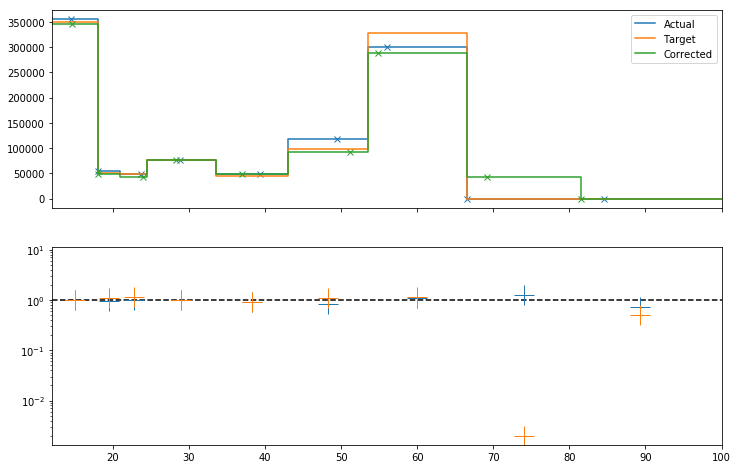

In [196]:
meanActual, meanCorrected, meanTarget = np.asarray(meanDict['actual']), np.asarray(meanDict['corrected']), np.asarray(meanDict['target'])
plt.hist(meanActual, bins=15, alpha=.5, label='Actual')
plt.hist(meanTarget, bins=15, alpha=.5, label='Target')
plt.hist(meanCorrected, bins=15, alpha=.5, label='Corrected')
plt.legend()
plt.show()

plt.hist(abs(meanActual - meanTarget), bins=15, alpha=.5)
plt.hist(abs(meanCorrected - meanTarget), bins=15, alpha=.5)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(np.append(getCorrectedBins(binEdges, histActual), 0), histActual, marker='x', ls='', color='C0')
ax[0].step(binEdges[:-1], histActual, where='post', label='Actual', color='C0')
ax[0].step(binEdges[:-1], histTarget, where='post', label='Target', color='C1')
ax[0].plot(np.append(getCorrectedBins(binEdges, histCorrected), 0), histCorrected, marker='x', ls='', color='C2')
ax[0].step(binEdges[:-1], histCorrected, where='post', label='Corrected', color='C2')
ax[1].axhline(y=1, ls='--', color='k')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histActual, markersize=20, ls='', marker='+')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histCorrected, markersize=20, ls='', marker='+')
ax[0].legend()
plt.xlim(12, 100)

[1.00000000e+00 3.79706445e-01 2.39037287e-01 1.02744097e-01
 6.99291304e-02 1.19792141e-01 3.32089735e-01 1.27632419e-04
 1.23515244e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[ 1.66666667e-01 -2.06764518e-01 -4.01911882e-02 -1.51436878e-02
 -3.45420701e-03  4.74885820e-03  1.63305841e-02 -2.21308069e-02
 -2.65624180e-07 -7.71970274e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.16666666666666666 -0.20676451818761965 0.09696502057613171 12.0
-0.20676451818761965 -0.040191188153627745 0.19438145628621814 18.0
-0.040191188153627745 -0.015143687766533971 0.376791243609131 21.0
-0.015143687766533971 -0.003454207008469348 0.22809549838334614 24.5
-0.003454207008469348 0.004748858197092694 0.2726236781329765 33.5
0.004748858197092694 0.016330584147578896 0.7092046338221931 43.0
0.016330584147578896 -0.022130806865969594 0.13104408604526901 53.5
-0.022130806865969594 -

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


[[0.7681255871672886, 6.926214921649903, 0.0, 0.27546501225093983, 43.56947524238566, 2.205053528288987, -4.664743205810374e-07, 3.485764293456002e-05, -0.0018876777745425591, 0.011343523561320547, 0.17389815920793694], [1.1521883807509328, 10.389322382474854, 7.0984231238866204, 0.4131975183764098, 65.35421286357848, 3.3075802924334807, -3.1098288038735835e-07, 5.228646440184002e-05, -0.0012584518496950396, 0.01701528534198082, 0.2608472388119054]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in divide


[[ 0.77433441  7.23724478]
 [ 6.92662596  0.41222108]
 [64.96201335  3.30750475]]


(0, 100)

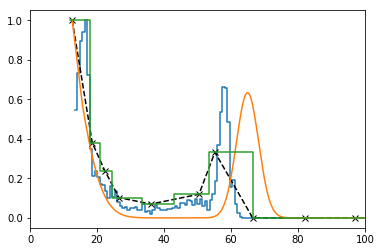

In [180]:
import scipy.interpolate

randomData = pixelData 
# randomData = list(np.random.normal(60, 1, 5000)) + list(np.random.normal(26, 1, 3000)) + list(np.random.normal(40, 10, 1000))
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

hist, bins = np.histogram(randomData, bins=binEdges, density=True)
hist /= max(hist)
print hist

# Use corrected bin centers
binEdges_ = getCorrectedBins(bins, hist)

# Show input data
histIn, binsIn = np.histogram(randomData, bins=100, density=True)
histIn /= max(histIn)
plt.step(binsIn[:-1], histIn, where='post')

# Plot corrected bin positions
hist_ = hist[:-1] # * np.diff(np.append(binEdges_, 0))
plt.plot(binEdges_, hist_/max(hist_), marker='x', ls='--', color='k')

# Find peaks
sign = np.sign(np.insert(np.diff(hist_), 0, 1))
sign = sign[sign != 0]
peakIdx = (np.argwhere(np.diff(sign) < 0) + 2).flatten()
print 'Peaks:', peakIdx

peaks = np.asarray(binEdges_)[peakIdx]
sigmas = [2] * len(peaks)
As = np.asarray(hist_/max(hist_))[peakIdx]
offsetList = [0.] * len(peaks)

def multiGaussPlot(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    return y

wBG, wAREA = False, False
def multiGauss(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    if wAREA:
        areaList = []
        for idx in range(len(binEdges) - 1):
            b1, b2 = binEdges[idx], binEdges[idx+1]
            y_ = yfine[np.logical_and(xfine >= b1, xfine < b2)]
            if not any(y_):
                areaList.append( 0 )
                continue
            x_ = xfine[np.logical_and(xfine >= b1, xfine < b2)]

            areaList.append( scipy.integrate.simps(y_, x_) )
            # print areaList
                
        areaList = np.asarray(areaList)
        areaList /= float(np.max(areaList))
        
        '''
        plt.clf()
        plt.step(bins[:-1], hist, where='post')
        plt.step(bins[:-1], areaList, where='post')
        plt.step(xfine, yfine, where='post')
        plt.xlim(12, 70)
        plt.show()
        '''
        
        error = np.asarray(hist) / areaList
        errMean, errStd = np.nanmean( error ), np.nanstd( error )
        error = np.nansum(np.abs( np.asarray(hist) / areaList - 1 ))
        # print error
        # print errStd
        return errStd
    
    else:
        errStd, error = 0, 0
        return np.sqrt(np.square(y - hist[:-1]))
    
def polyArea(x, poly):
    return np.asarray([1./(k + 1) * x**(k + 1) for k in range(len(poly))])

def multiGaussArea(x1, x2, *p):
    # poly = p[-3:]
    # pA = np.sum(polyArea(x2, poly) - polyArea(x1, poly))
    x = np.linspace(x1, x2, 100)
    return scipy.integrate.simps(multiGauss(x, *p), x) # scipy.integrate.quad(multiGauss, x1, x2)[0]

p0 = np.hstack((np.vstack((As, peaks, sigmas)).T.flatten(), [0.001]*5)).flatten()
bounds = [[0, 0, 0] * len(peaks) + [-np.inf]*5, [1, np.inf, np.inf]*len(peaks) + [np.inf]*5]
# bounds[1][2], bounds[1][5] = 3., 3.
print bounds
print p0
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=p0, bounds=bounds)
wBG = True
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
wAREA = True
bounds = [[0.8*p if p >= 0 else 1.2*p for p in popt], [1.2*p if p >= 0 else 0.8*p for p in popt]]
bounds[0][2] = 0.
# bounds[1][2] = 5.

print bounds
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
print np.reshape(popt[:-5], (3, -1))

# p = np.polyfit(x_, hist__/max(hist__), 13)
# f = np.poly1d(p)
# f = scipy.interpolate.interp1d(binEdges_, hist_/max(hist_), kind='cubic')
# f = KDE(np.append(binEdges_, 0), hist_)

x = np.linspace(min(binEdges_), max(binEdges_), 1000)
wArea = False
yFit = multiGaussPlot(x, *popt)
plt.plot(x, yFit / np.max(yFit))

# plt.plot(x, f(x))
plt.step(bins[:-1], hist, where='post')
plt.xlim(0, 100)
# plt.ylim(0, 1.05)

In [20]:
test = np.linspace(12, 15, 100)
scipy.integrate.simps(multiGauss(test, *p0), test)

0.5925000046377458

In [31]:
areaList = []
for idx in range(len(binEdges) - 1):
    b1, b2 = binEdges[idx], binEdges[idx+1]
    areaList.append( scipy.integrate.simps(np.linspace(b1, b2, 100), *p) )
    print areaList

areaList = np.asarray(areaList)
error = np.sqrt( np.sum(np.square( np.asarray(hist) / areaList - 1 )) )


TypeError: simps() takes at most 5 arguments (7 given)